# CICERO SCM notebook example - interactive input

Import some stuff

In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Import the model

In [2]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [3]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

In [4]:
def to_df(cscm):
    out=pd.concat([pd.DataFrame(v) for k, v in cscm.results.items()], axis = 1, keys = list(cscm.results.keys()))
    return out

set up input directories

In [5]:
test_data_dir = os.path.join(os.getcwd(), '../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [6]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [7]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,270.9068
1752,273.0183
1753,272.0470
1754,271.1915


Read forcing

In [8]:
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [9]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.054710,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.927690,1.353250,12.520269,0.744520,2.927399
1751,0.002593,0.082619,18.915109,0.055744,1.206598,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828060,343.926367,59.088126,6.860142,1.335274,12.279280,0.737652,2.909437
1752,0.002594,0.084139,18.889712,0.056797,1.200955,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828658,341.809034,58.631997,6.819482,1.326617,12.121816,0.737695,2.912659
1753,0.002594,0.085687,19.121377,0.057870,1.207757,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.812105,343.675456,59.026349,6.881439,1.328560,12.249330,0.743391,2.933215
1754,0.002595,0.087263,19.509061,0.058963,1.233495,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.841598,349.815625,60.269945,7.015189,1.346553,12.593635,0.752796,2.965138


# Set up model run with defined input variables

In [28]:
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
            "carbon_cycle_model":"box"
        })

In [29]:
cscm_dir.ce_handler.carbon_cycle

and run it!

In [ ]:
# NBVAL_IGNORE_OUTPUT
cscm_dir._run({
            "results_as_dict":True
        },
    pamset_udm={"threstemp": 7.0, #scales vertical velocity as a function of mixed layer temperature
                    "rlamdo":16.0,#air-sea heat exchange coefficient (wm^-2K^-1)
                    "akapa":0.634, #vertical heat diffusivity
                    "cpi":0.4, #temperature change ratio: polar to nonpolar region
                    "W":4, #vertical velocity (m/yr)
                    "beto":3.5, #ocean interhemispheric heat exchange coeff (Wm^-2K^-1)
                    "lambda":3.74 / 3,
                    "mixed":60.0,  #mixed layer depth
                    "foan":0.61, #fraction of northern hemisphere covered by ocean
                    "foas":0.81, #fraction of northern hemisphere covered by ocean
                    "ebbeta":0.0,#atmospheric interhemispheric heat exchange 
                    "fnso":0.7531, #ocean area ratio, northern to southern hemisphere
                    "lm":40, #number of vertical layers
                    "ldtime":12,
                   },
    pamset_emiconc={"lamb": 0.8,
                    "qbmb":0.03,
                    "qo3":0.4,
                    "qdirso2":-.457,
                    "qindso2":-.514,
                    "qbc":.2,
                    "qh2o_ch4":.171,
                    "qoc":-.103,
                    "ref_yr":2010,
                    "idtm":24})

List available output

In [20]:
cscm_dir.ce_handler.carbon_cycle

In [12]:
cscm_dir.results.keys()

dict_keys(['OHC700', 'OHCTOT', 'RIB_glob', 'RIB_N', 'RIB_S', 'dT_glob', 'dT_NH', 'dT_SH', 'dT_glob_air', 'dT_NH_air', 'dT_SH_air', 'dT_glob_sea', 'dT_NH_sea', 'dT_SHsea', 'Total_forcing', 'Solar_forcing', 'Volcanic_forcing_NH', 'Volcanic_forcing_SH', 'emissions', 'concentrations', 'forcing'])

Convert the output to a dataframe for easy handling

In [13]:

df_temp = to_df(cscm_dir)


In [14]:
df_temp['concentrations']

,Year,CO2,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,TROP_O3,STRAT_O3,STRAT_H2O,BMB_AEROS_BC,BMB_AEROS_OC,BMB_AEROS,LANDUSE,BC,OC,OTHER
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,2096.0,549.935558,1695.429816,410.879525,0.0,47.633214,223.445983,25.869700,10.598126,9.187147,...,24.472387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097,2097.0,549.416128,1692.139826,411.054259,0.0,46.642693,221.223060,25.567134,10.542495,9.181024,...,24.421483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2098,2098.0,548.850270,1689.009825,411.217555,0.0,45.671310,219.022313,25.268107,10.487155,9.174790,...,24.371187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2099,2099.0,548.237964,1686.019842,411.368452,0.0,44.718645,216.843521,24.972577,10.432106,9.168445,...,24.321426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# NBVAL_IGNORE_OUTPUT
df_temp.head()

OHC700 OHCTOT RIB_glob RIB_N RIB_S   dT_glob dT_NH dT_SH dT_glob_air  \
       0      0        0     0     0         0     0     0           0   
0    0.0    0.0      0.0   0.0   0.0  0.000000   0.0   0.0         0.0   
1    0.0    0.0      0.0   0.0   0.0 -0.000143   0.0   0.0         0.0   
2    0.0    0.0      0.0   0.0   0.0 -0.000178   0.0   0.0         0.0   
3    0.0    0.0      0.0   0.0   0.0  0.000226   0.0   0.0         0.0   
4    0.0    0.0      0.0   0.0   0.0  0.001271   0.0   0.0         0.0   

  dT_NH_air  ...  forcing                                                \
          0  ... STRAT_O3 STRAT_H2O BMB_AEROS_BC BMB_AEROS_OC BMB_AEROS   
0       0.0  ...      NaN       NaN          NaN          NaN       NaN   
1       0.0  ...      NaN       NaN          NaN          NaN       NaN   
2       0.0  ...      NaN       NaN          NaN          NaN       NaN   
3       0.0  ...      NaN       NaN          NaN          NaN       NaN   
4       0.0  ...      NaN       NaN          NaN          NaN       NaN   

                                       
  LANDUSE  BC  OC OTHER Total_forcing  
0     NaN NaN NaN   NaN           NaN  
1     NaN NaN NaN   NaN           NaN  
2     NaN NaN NaN   NaN           NaN  
3     NaN NaN NaN   NaN           NaN  
4     NaN NaN NaN   NaN           NaN  

[5 rows x 153 columns]

# Plot output

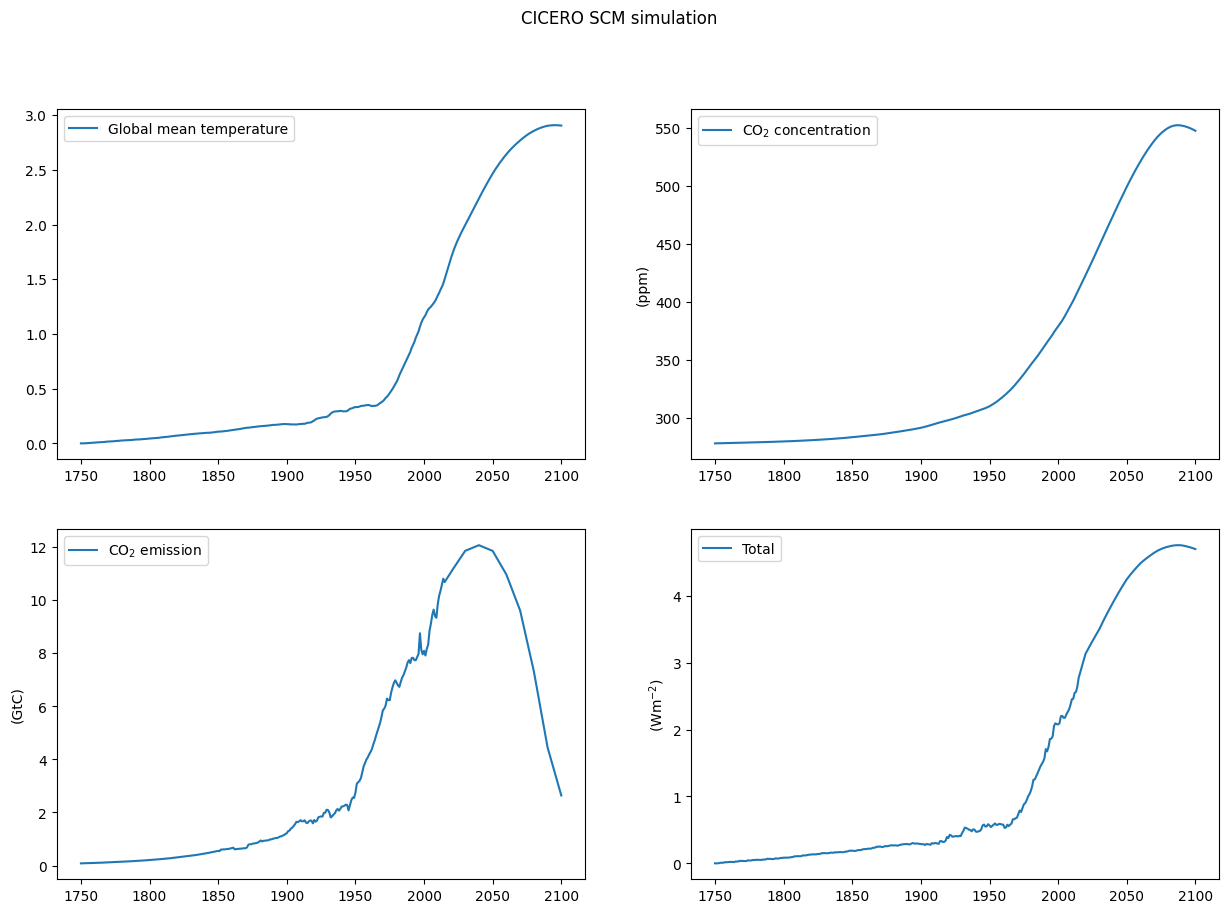

In [16]:
# NBVAL_IGNORE_OUTPUT
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
axs=axs.flatten()
fig.suptitle('CICERO SCM simulation')

axs[0].plot(1750+np.arange(len(df_temp['dT_glob'])),df_temp['dT_glob'])
axs[0].legend(['Global mean temperature','NH temperature','SH temperature'])

df_temp['concentrations']['CO2'].plot(ylabel='(ppm)',ax=axs[1])
axs[1].legend([r'CO$_2$ concentration'])

df_temp['emissions']['CO2'].plot(ylabel='(GtC)',ax=axs[2])
axs[2].legend([r'CO$_2$ emission'])

df_temp['forcing']['Total_forcing'].plot(ylabel='(Wm$^{-2}$)',ax=axs[3])

axs[3].legend([r'Total','CO$_2$','CH$_4$','Land Use'])

In [17]:
for i in enumerate(df_temp.columns):
    print(i)

(0, ('OHC700', 0))
(1, ('OHCTOT', 0))
(2, ('RIB_glob', 0))
(3, ('RIB_N', 0))
(4, ('RIB_S', 0))
(5, ('dT_glob', 0))
(6, ('dT_NH', 0))
(7, ('dT_SH', 0))
(8, ('dT_glob_air', 0))
(9, ('dT_NH_air', 0))
(10, ('dT_SH_air', 0))
(11, ('dT_glob_sea', 0))
(12, ('dT_NH_sea', 0))
(13, ('dT_SHsea', 0))
(14, ('Total_forcing', 0))
(15, ('Solar_forcing', 0))
(16, ('Volcanic_forcing_NH', 0))
(17, ('Volcanic_forcing_SH', 0))
(18, ('emissions', 'Year'))
(19, ('emissions', 'CO2'))
(20, ('emissions', 'CH4'))
(21, ('emissions', 'N2O'))
(22, ('emissions', 'SO2'))
(23, ('emissions', 'CFC-11'))
(24, ('emissions', 'CFC-12'))
(25, ('emissions', 'CFC-113'))
(26, ('emissions', 'CFC-114'))
(27, ('emissions', 'CFC-115'))
(28, ('emissions', 'CH3Br'))
(29, ('emissions', 'CCl4'))
(30, ('emissions', 'CH3CCl3'))
(31, ('emissions', 'HCFC-22'))
(32, ('emissions', 'HCFC-141b'))
(33, ('emissions', 'HCFC-123'))
(34, ('emissions', 'HCFC-142b'))
(35, ('emissions', 'H-1211'))
(36, ('emissions', 'H-1301'))
(37, ('emissions', 'H-24